In [2]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
#import scienceplots
import tensorflow as tf
from sklearn.model_selection import train_test_split
import random
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
import tensorflow.keras.callbacks
from keras import backend as K
from keras.regularizers import l2
import albumentations as A

In [3]:
train_transforms = A.Compose([
    A.VerticalFlip(),
    A.HorizontalFlip(),
    A.Rotate(limit=30),
    A.GaussNoise(var_limit=0.01)
])

val_transforms = A.Compose([
    A.NoOp()
])

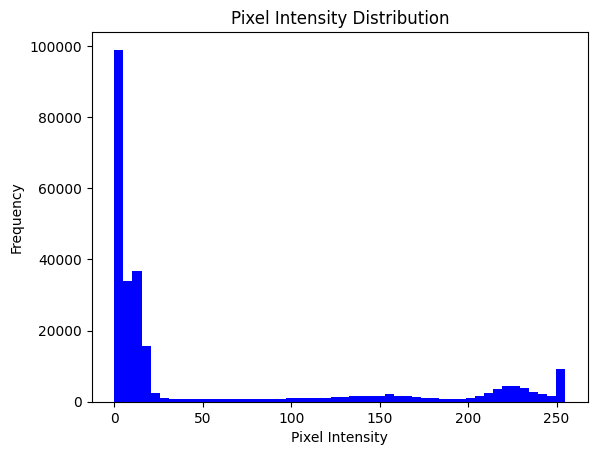

In [4]:
image = cv2.imread(r"C:\Users\stepan\ML\datasets\multiclass_semantic_liver-tumor\Train_Ct-Scan\volume-0_slice_56.jpg", cv2.IMREAD_GRAYSCALE)

hist = cv2.calcHist([image], [0], None, [256], [0, 256])

plt.hist(image.flatten(), bins=50, color='blue')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.title('Pixel Intensity Distribution')
plt.show()

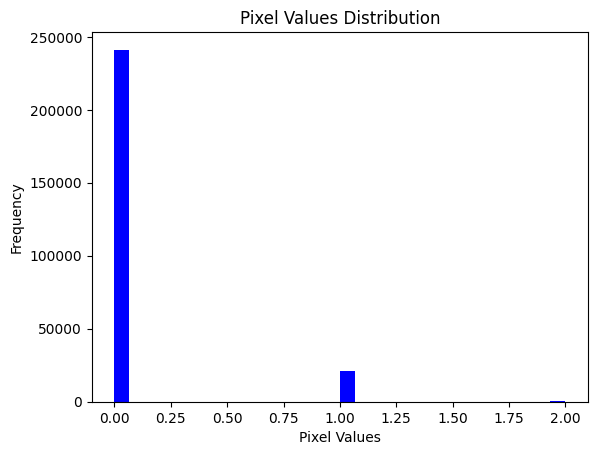

In [5]:
mask = cv2.imread(r"C:\Users\stepan\ML\datasets\multiclass_semantic_liver-tumor\Train_Ct-Scan_masks\volume-0_slice_56.tiff", cv2.IMREAD_GRAYSCALE)


plt.hist(mask.flatten(), bins=30, color='blue')
plt.xlabel('Pixel Values')
plt.ylabel('Frequency')
plt.title('Pixel Values Distribution')
plt.show()

In [6]:
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(9, 9))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.title(' '.join(name.split('_')).title())

        if 'mask' in name:
            if image.ndim == 3 and image.shape[-1] > 1:
                image = np.argmax(image, axis=-1)
                
        plt.imshow(image, cmap = 'bone')
    plt.show()

In [7]:
def read_image(x):
    x = cv2.imread(x, cv2.IMREAD_GRAYSCALE)
    x = x / 255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    x = np.repeat(x, 3, axis=-1)
    return x

def read_mask(x):
    x = cv2.imread(x, cv2.IMREAD_GRAYSCALE)
    x = x.astype(np.int32)
    return x

In [8]:
def load_data(x_path, y_path):
    images = os.listdir(x_path)
    masks = os.listdir(y_path)
    
    X = [os.path.join(x_path, image) for image in images]
    y = [os.path.join(y_path, mask) for mask in masks]
    
    train_x, val_x, train_y, val_y = train_test_split(X, y, test_size=0.2, random_state=42)
    train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=0.25, random_state=42)

    return train_x, train_y, val_x, val_y, test_x, test_y

In [9]:
def tf_dataset(x, y, transformations, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x,y))
    dataset = dataset.shuffle(buffer_size=len(x))
    dataset = dataset.map(lambda x, y: preprocess(x, y, transformations))
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(2)
    return dataset

def preprocess(x, y, transformations):

    def aug(x,y):
        x = x.decode()
        y = y.decode()
        image = read_image(x)
        mask = read_mask(y)
        augmented = transformations(image=image,mask=mask)
        aug_img=augmented['image']
        aug_mask = augmented['mask']
        return aug_img, aug_mask
    
    image, mask = tf.numpy_function(aug, [x,y], [tf.float32, tf.int32])

    mask = tf.one_hot(mask, 3, dtype = tf.int32) #обязательно так как сегментация мультиклассовая

    image.set_shape([512,512,3])
    mask.set_shape([512,512,3])

    return image, mask

In [10]:
# def dice_coef(y_true, y_pred, smooth=1):
#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)
#     intersection = K.sum(y_true_f * y_pred_f)
#     return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# def dice_coef_3Class(y_true, y_pred, numLabels=3):
#     dice=0
#     for index in range(numLabels):
#         dice += dice_coef(y_true[:,:,:,index], y_pred[:,:,:,index])
#     return dice/numLabels

In [11]:
Ncl = 3
w = K.zeros(shape=(Ncl,))

def generalized_dice_coeff(y_true, y_pred):
    y_pred = K.cast(y_pred, 'float32')
    y_true = K.cast(y_true, 'float32')
    w = K.sum(y_true, axis=(0,1,2))
    w = 1.0/(w**2+0.000001)

    numerator = y_true*y_pred
    numerator = w*K.sum(numerator,(0,1,2))
    numerator = K.sum(numerator)

    denominator = y_true+y_pred
    denominator = w*K.sum(denominator,(0,1,2))
    denominator = K.sum(denominator)

    gen_dice_coef = 2*numerator/denominator

    return gen_dice_coef

def generalized_dice_loss(y_true, y_pred):
    return 1 - generalized_dice_coeff(y_true, y_pred)

In [12]:
class LossHistory(tensorflow.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

## Гиперпараметры для моделей

In [13]:
IMG_HEIGHT = 512
IMG_WIDTH = 512
IMG_CHANNELS = 3
n_classes = 3

LR = 1e-4
epochs = 50

## Формирование датасета и Визуализация

In [14]:
np.random.seed(42)
tf.random.set_seed(42)
batch_size = 4

images_path = r"C:\Users\stepan\ML\datasets\multiclass_semantic_liver-tumor\Train_Ct-Scan"
masks_path = r"C:\Users\stepan\ML\datasets\multiclass_semantic_liver-tumor\Train_Ct-Scan_masks"

train_x, train_y, val_x, val_y, test_x, test_y = load_data(images_path, masks_path)

train_ds = tf_dataset(train_x, train_y, transformations=train_transforms, batch=batch_size)
val_ds = tf_dataset(val_x, val_y, transformations=val_transforms, batch=batch_size)

(4, 512, 512, 3)
0


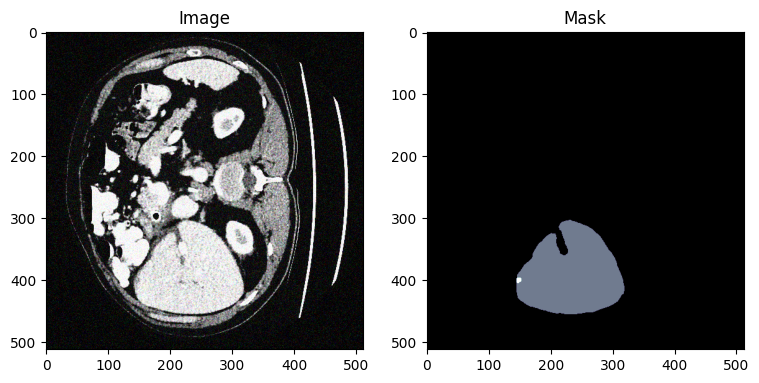

1


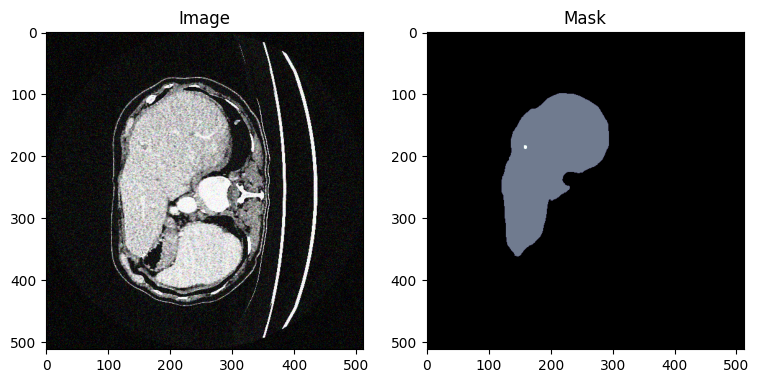

2


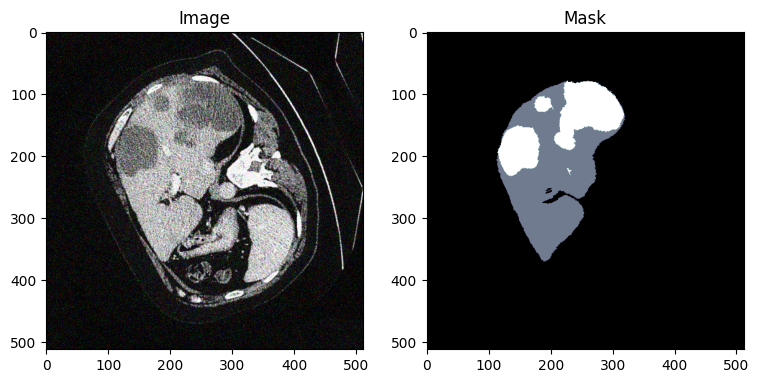

3


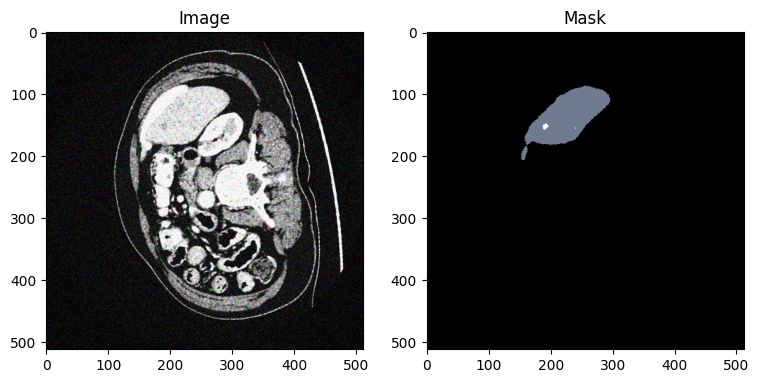

In [14]:
for images, labels in train_ds.take(1): 
    numpy_images = images.numpy()
    numpy_masks = labels.numpy()
    print(numpy_masks.shape)
    for i in range(numpy_images.shape[0]):
        print(i)
        visualize(image = numpy_images[i, ...], mask = numpy_masks[i, ...])

In [15]:
train_steps = len(train_x)//batch_size
valid_steps = len(val_x)//batch_size

## модель классический Unet

In [16]:
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, concatenate, Conv2DTranspose, Activation, BatchNormalization, Dropout, Lambda

def UNet(n_classes=3, IMG_HEIGHT=512, IMG_WIDTH=512, IMG_CHANNELS=3):
  
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)
    s = inputs

    #contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    #bottleneck
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #expansion path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs], name='UNET')
    
    return model

## Модель resunet plus plus 

In [16]:
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model
from keras.layers import Multiply, Add, GlobalAveragePooling2D, Reshape, Dense

def SE(inputs, ratio=8):
    channel_axis = -1
    num_filters = inputs.shape[channel_axis]
    se_shape = (1, 1, num_filters)

    x = GlobalAveragePooling2D()(inputs)
    x = Reshape(se_shape)(x)
    x = Dense(num_filters // ratio, activation='relu', use_bias=False)(x)
    x = Dense(num_filters, activation='sigmoid', use_bias=False)(x)

    x = Multiply()([inputs, x])
    return x


def stem_block(inputs, num_filters):
    ## Conv 1
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(num_filters, 3, padding="same")(x)

    ## Shortcut
    s = Conv2D(num_filters, 1, padding="same")(inputs)

    ## Add
    x = Add()([x, s])
    return x

def resnet_block(inputs, num_filters, strides=1):
    ## SE
    inputs = SE(inputs)

    ## Conv 1
    x = BatchNormalization()(inputs)
    x = Activation("relu")(x)
    x = Conv2D(num_filters, 3, padding="same", strides=strides)(x)

    ## Conv 2
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(num_filters, 3, padding="same", strides=1)(x)

    ## Shortcut
    s = Conv2D(num_filters, 1, padding="same", strides=strides)(inputs)

    ## Add
    x = Add()([x, s])

    return x

def aspp_block(inputs, num_filters):
    x1 = Conv2D(num_filters, 3, dilation_rate=6, padding="same")(inputs)
    x1 = BatchNormalization()(x1)

    x2 = Conv2D(num_filters, 3, dilation_rate=12, padding="same")(inputs)
    x2 = BatchNormalization()(x2)

    x3 = Conv2D(num_filters, 3, dilation_rate=18, padding="same")(inputs)
    x3 = BatchNormalization()(x3)

    x4 = Conv2D(num_filters, (3, 3), padding="same")(inputs)
    x4 = BatchNormalization()(x4)

    y = Add()([x1, x2, x3, x4])
    y = Conv2D(num_filters, 1, padding="same")(y)

    return y

def attetion_block(x1, x2):
    num_filters = x2.shape[-1]

    x1_conv = BatchNormalization()(x1)
    x1_conv = Activation("relu")(x1_conv)
    x1_conv = Conv2D(num_filters, 3, padding="same")(x1_conv)
    x1_pool = MaxPooling2D((2, 2))(x1_conv)

    x2_conv = BatchNormalization()(x2)
    x2_conv = Activation("relu")(x2_conv)
    x2_conv = Conv2D(num_filters, 3, padding="same")(x2_conv)

    x = Add()([x1_pool, x2_conv])

    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(num_filters, 3, padding="same")(x)

    x = Multiply()([x, x2])
    return x

def resunet_pp(n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS):

    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    # encoding
    c1 = stem_block(inputs, 16)
    c2 = resnet_block(c1, 32, strides=2)
    c3 = resnet_block(c2, 64, strides=2)
    c4 = resnet_block(c3, 128, strides=2)

    # bridge
    b1 = aspp_block(c4, 256)

    # decoding
    d1 = attetion_block(c3, b1)
    d1 = UpSampling2D((2, 2))(d1)
    d1 = Concatenate()([d1, c3])
    d1 = resnet_block(d1, 128)

    d2 = attetion_block(c2, d1)
    d2 = UpSampling2D((2, 2))(d2)
    d2 = Concatenate()([d2, c2])
    d2 = resnet_block(d2, 64)

    d3 = attetion_block(c1, d2)
    d3 = UpSampling2D((2, 2))(d3)
    d3 = Concatenate()([d3, c1])
    d3 = resnet_block(d3, 32)

    outputs = aspp_block(d3, 16)
    outputs = Conv2D(n_classes, 1, padding="same")(outputs)
    outputs = Activation("softmax")(outputs)

    model = Model(inputs, outputs, name='RESUNET_pp')
    return model

VGG16 unet

In [18]:
from tensorflow.keras.applications import VGG16

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x


def vgg16_unet(n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    vgg16 = VGG16(include_top=False, weights="imagenet", input_tensor=inputs)

    s1 = vgg16.get_layer("block1_conv2").output
    s2 = vgg16.get_layer("block2_conv2").output
    s3 = vgg16.get_layer("block3_conv3").output
    s4 = vgg16.get_layer("block4_conv3").output

    b1 = vgg16.get_layer("block5_conv3").output

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(n_classes, 1, padding="same", activation="softmax")(d4)

    model = Model(inputs, outputs, name="VGG16_UNet")
    return model

In [19]:
unet_model = UNet(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)
unet_model.compile(loss=generalized_dice_loss, optimizer=tf.keras.optimizers.Adam(LR), metrics = [tf.keras.metrics.OneHotMeanIoU(num_classes=3)])
unet_model.summary()

Model: "UNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 512, 512, 16  0           ['conv2d[0][0]']                 
                                )                                                              

In [17]:
resunet_pp_model = resunet_pp(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)
resunet_pp_model.compile(loss=generalized_dice_loss, optimizer=tf.keras.optimizers.Adam(LR), metrics = [tf.keras.metrics.OneHotMeanIoU(num_classes=3)])
resunet_pp_model.summary()

Model: "RESUNET_pp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                        

In [20]:
vgg16unet_model = vgg16_unet(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)
vgg16unet_model.compile(loss=generalized_dice_loss, optimizer=tf.keras.optimizers.Adam(LR), metrics = [tf.keras.metrics.OneHotMeanIoU(num_classes=3)])
vgg16unet_model.summary()

Model: "VGG16_UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 512, 512, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 512, 512, 64  36928       ['block1_conv1[0][0]']           
                                )                                                        

## Обучение unet

In [21]:
history_class = LossHistory()

callbacks = [
    ModelCheckpoint("UNet.hdf5", verbose=1, save_best_model=True),
    ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.1, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor="val_loss", patience=3, verbose=1,min_delta=0.0001),
    TensorBoard(log_dir='logs_unet'),
    history_class
]

unet_model_history = unet_model.fit(train_ds,
                    steps_per_epoch=train_steps,validation_data=val_ds,
                    validation_steps=valid_steps,epochs=epochs,
                    callbacks=callbacks,verbose = 1)
unet_model.save('final_UNet.hdf5')

unet_hist_df = pd.DataFrame(unet_model_history.history)

hist_csv_file = 'history_unet.csv'
with open(hist_csv_file, mode='w') as f:
    unet_hist_df.to_csv(f)

Epoch 1/50
1077/1077 [==============================] - ETA: 0s - loss: 0.9231 - one_hot_mean_io_u: 0.0412
Epoch 1: saving model to UNet.hdf5
1077/1077 [==============================] - 191s 168ms/step - loss: 0.9231 - one_hot_mean_io_u: 0.0412 - val_loss: 0.9181 - val_one_hot_mean_io_u: 0.0275 - lr: 1.0000e-04
Epoch 2/50
1077/1077 [==============================] - ETA: 0s - loss: 0.9192 - one_hot_mean_io_u: 0.0277
Epoch 2: saving model to UNet.hdf5
1077/1077 [==============================] - 175s 161ms/step - loss: 0.9192 - one_hot_mean_io_u: 0.0277 - val_loss: 0.9178 - val_one_hot_mean_io_u: 0.0282 - lr: 1.0000e-04
Epoch 3/50
1077/1077 [==============================] - ETA: 0s - loss: 0.8647 - one_hot_mean_io_u: 0.2507
Epoch 3: saving model to UNet.hdf5
1077/1077 [==============================] - 174s 161ms/step - loss: 0.8647 - one_hot_mean_io_u: 0.2507 - val_loss: 0.8243 - val_one_hot_mean_io_u: 0.4847 - lr: 1.0000e-04
Epoch 4/50
1077/1077 [==============================] - ET

## Обучение resunet_pp

In [18]:
history_class = LossHistory()

callbacks = [
    ModelCheckpoint("resunet_pp.hdf5", verbose=1, save_best_model=True),
    ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.1, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor="val_loss", patience=3, verbose=1,min_delta=0.0001),
    TensorBoard(log_dir='logs_resunet_pp'),
    history_class
]

resunet_pp_model_history = resunet_pp_model.fit(train_ds,
                    steps_per_epoch=train_steps,validation_data=val_ds,
                    validation_steps=valid_steps,epochs=epochs,
                    callbacks=callbacks,verbose = 1)
resunet_pp_model.save('final_resunet_pp.hdf5')

resunet_pp_hist_df = pd.DataFrame(resunet_pp_model_history.history)

hist_csv_file = 'history_resunet_pp.csv'
with open(hist_csv_file, mode='w') as f:
    resunet_pp_hist_df.to_csv(f)

Epoch 1/50
1077/1077 [==============================] - ETA: 0s - loss: 0.5160 - one_hot_mean_io_u: 0.5531
Epoch 1: saving model to resunet_pp.hdf5
1077/1077 [==============================] - 724s 656ms/step - loss: 0.5160 - one_hot_mean_io_u: 0.5531 - val_loss: 0.4686 - val_one_hot_mean_io_u: 0.6482 - lr: 1.0000e-04
Epoch 2/50
1077/1077 [==============================] - ETA: 0s - loss: 0.3605 - one_hot_mean_io_u: 0.7389
Epoch 2: saving model to resunet_pp.hdf5
1077/1077 [==============================] - 674s 623ms/step - loss: 0.3605 - one_hot_mean_io_u: 0.7389 - val_loss: 0.3569 - val_one_hot_mean_io_u: 0.7421 - lr: 1.0000e-04
Epoch 3/50
1077/1077 [==============================] - ETA: 0s - loss: 0.3075 - one_hot_mean_io_u: 0.7719
Epoch 3: saving model to resunet_pp.hdf5
1077/1077 [==============================] - 658s 611ms/step - loss: 0.3075 - one_hot_mean_io_u: 0.7719 - val_loss: 0.2867 - val_one_hot_mean_io_u: 0.7852 - lr: 1.0000e-04
Epoch 4/50
1077/1077 [==================

## Обучение vgg16_unet (не трогать!!!)

In [21]:
history_class = LossHistory()

callbacks = [
    ModelCheckpoint("vgg16unet_model.hdf5", verbose=1, save_best_model=True),
    ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.1, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor="val_loss", patience=3, verbose=1,min_delta=0.0001),
    TensorBoard(log_dir='logs'),
    history_class
]

vgg16unet_model_history = vgg16unet_model.fit(train_ds,
                    steps_per_epoch=train_steps,validation_data=val_ds,
                    validation_steps=valid_steps,epochs=epochs,
                    callbacks=callbacks,verbose = 1)
vgg16unet_model.save('final_vgg16unet_model.hdf5')

vgg16unet_hist_df = pd.DataFrame(vgg16unet_model_history.history)

hist_csv_file = 'history_vgg16unet.csv'
with open(hist_csv_file, mode='w') as f:
    vgg16unet_hist_df.to_csv(f)

Epoch 1/50
1077/1077 [==============================] - ETA: 0s - loss: 0.5646 - one_hot_mean_io_u: 0.3920
Epoch 1: saving model to vgg16unet_model.hdf5
1077/1077 [==============================] - 762s 692ms/step - loss: 0.5646 - one_hot_mean_io_u: 0.3920 - val_loss: 0.4126 - val_one_hot_mean_io_u: 0.6454 - lr: 1.0000e-04
Epoch 2/50
1077/1077 [==============================] - ETA: 0s - loss: 0.3728 - one_hot_mean_io_u: 0.7073
Epoch 2: saving model to vgg16unet_model.hdf5
1077/1077 [==============================] - 748s 691ms/step - loss: 0.3728 - one_hot_mean_io_u: 0.7073 - val_loss: 0.4258 - val_one_hot_mean_io_u: 0.6973 - lr: 1.0000e-04
Epoch 3/50
1077/1077 [==============================] - ETA: 0s - loss: 0.3402 - one_hot_mean_io_u: 0.7411
Epoch 3: saving model to vgg16unet_model.hdf5
1077/1077 [==============================] - 744s 691ms/step - loss: 0.3402 - one_hot_mean_io_u: 0.7411 - val_loss: 0.3141 - val_one_hot_mean_io_u: 0.7583 - lr: 1.0000e-04
Epoch 4/50
1077/1077 [===

NameError: name 'model' is not defined

## Визуализация результатов обучения

In [16]:
vgg16_unet = tf.keras.models.load_model('final_vgg16unet_model.hdf5', compile=False)
unet = tf.keras.models.load_model('final_UNet.hdf5', compile=False)
resunet_plus_plus = tf.keras.models.load_model('final_resunet_pp.hdf5', compile=False)

In [3]:
unet_history = pd.read_csv('history_unet.csv')
resunet_pp_history = pd.read_csv('history_resunet_pp.csv')
vgg16_unet_history = pd.read_csv('history_vgg16unet.csv')

In [8]:
def plot_history(history, metrics=["one_hot_mean_io_u", "val_one_hot_mean_io_u"], losses=["loss", "val_loss"]):
    plt.style.use(['tableau-colorblind10'])
    plt.figure(figsize=(12, 6))
    for metric in metrics:
        plt.plot(history[metric], linewidth=3)

    plt.suptitle("metrics over epochs", fontsize=20)
    plt.ylabel("metric", fontsize=20)
    plt.xlabel("epoch", fontsize=20)
    plt.legend(metrics, loc="center right", fontsize=15)
    plt.show()

    plt.figure(figsize=(12, 6))
    for loss in losses:
        plt.plot(history[loss], linewidth=3)

    plt.suptitle("loss over epochs", fontsize=20)
    plt.ylabel("loss", fontsize=20)
    plt.xlabel("epoch", fontsize=20)
    plt.legend(losses, loc="center right", fontsize=15)
    plt.show()

Графики обучения Unet

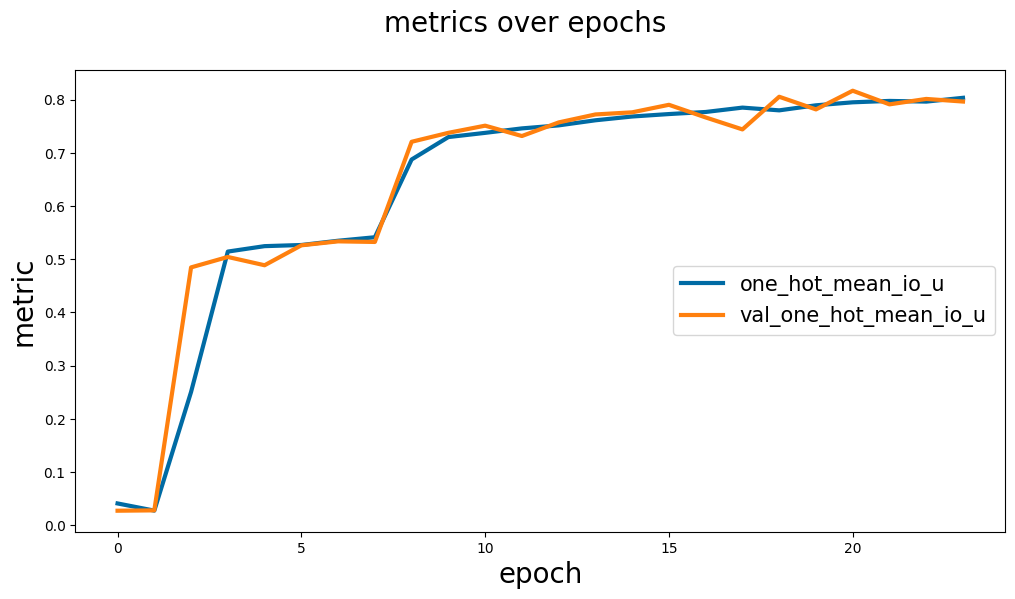

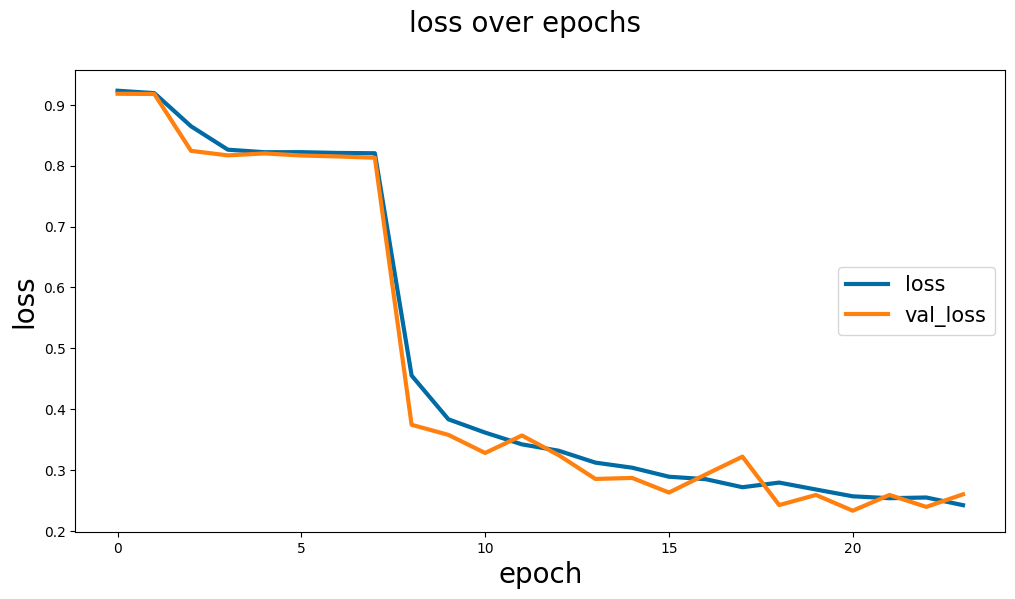

In [9]:
plot_history(unet_history)

Графики обучения vgg16 unet

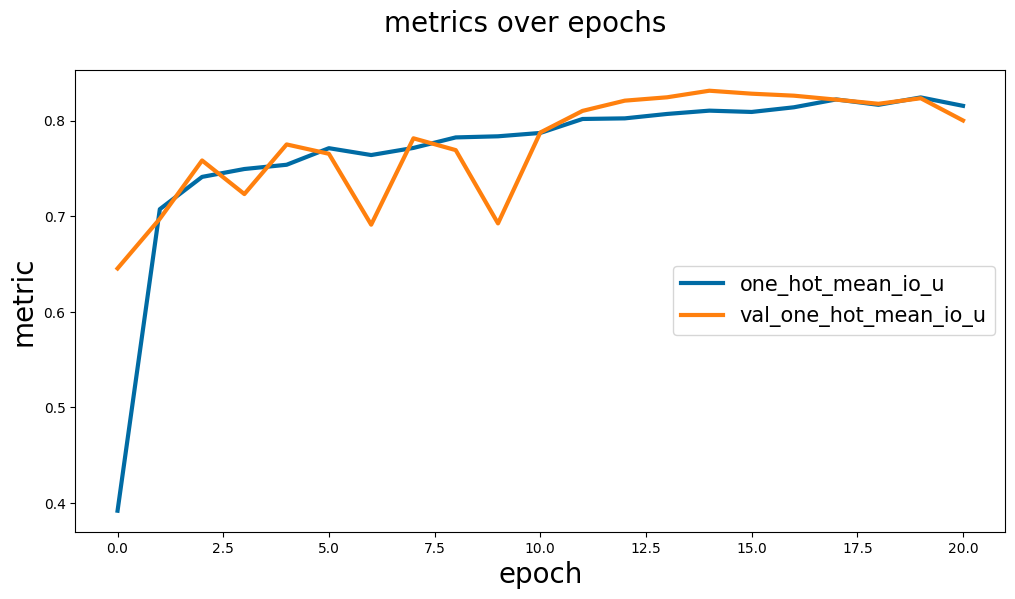

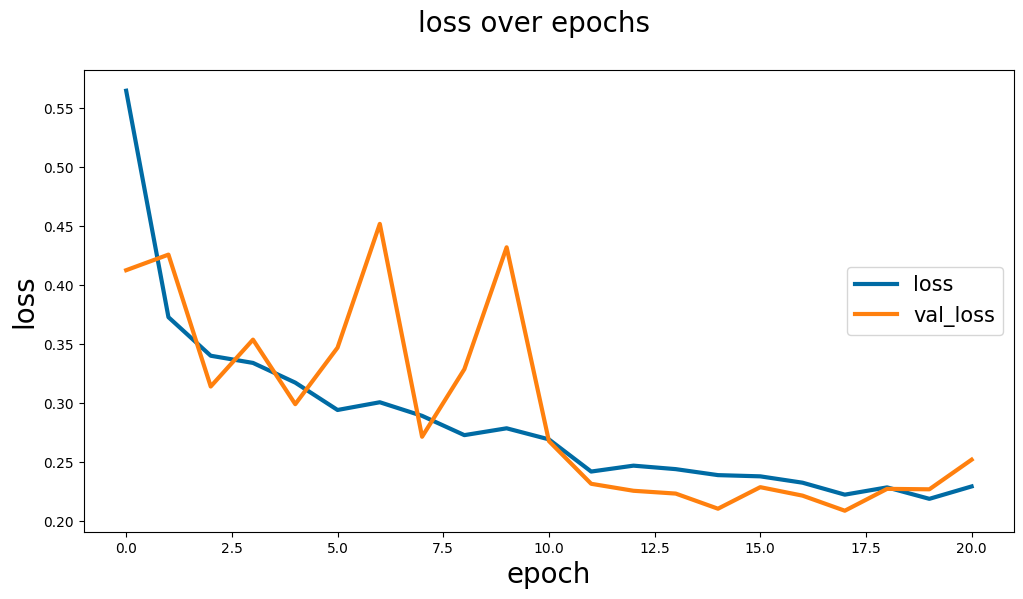

In [10]:
plot_history(vgg16_unet_history)

Графики обучения ResUnet plus plus

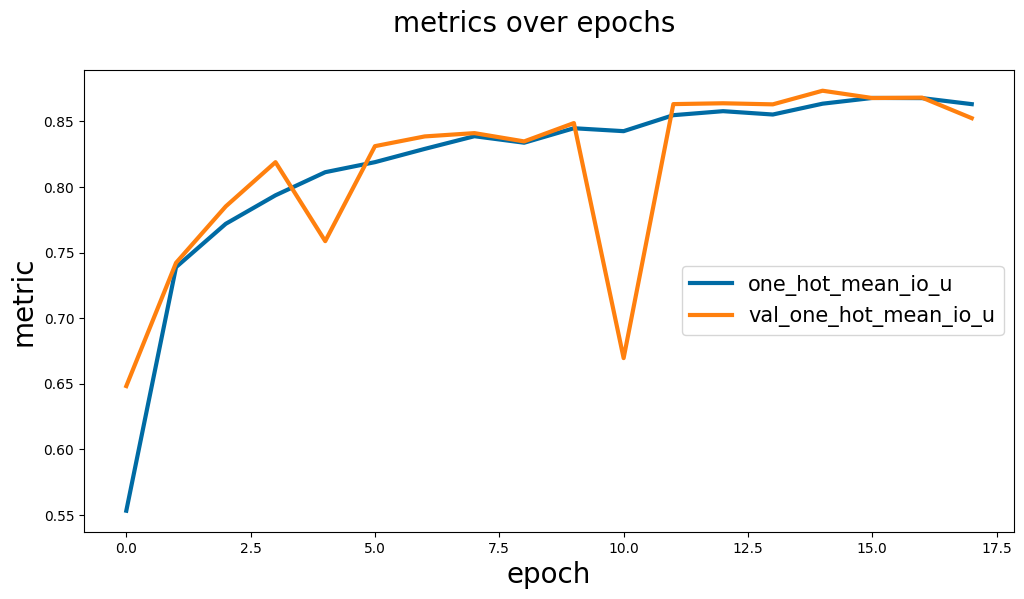

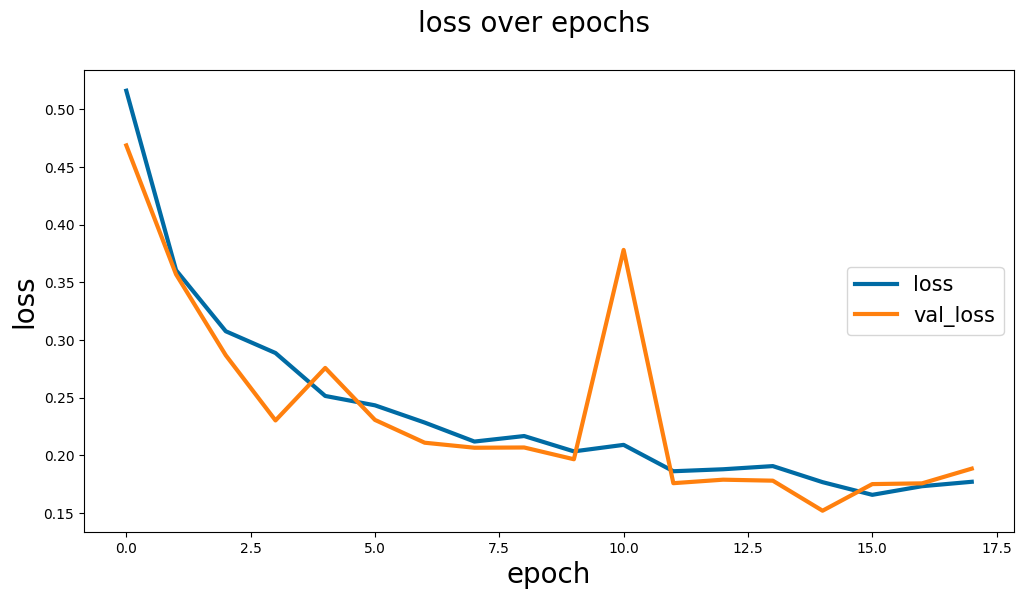

In [11]:
plot_history(resunet_pp_history)

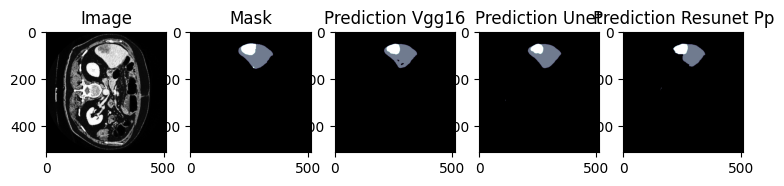

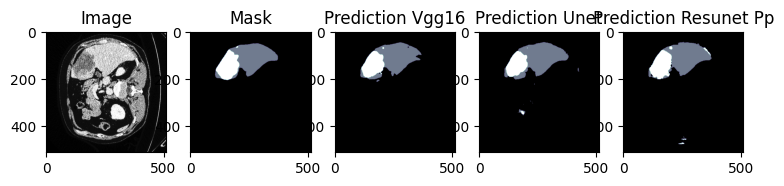

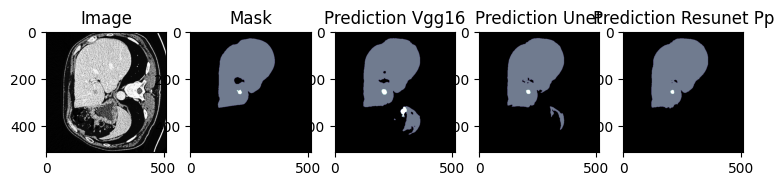

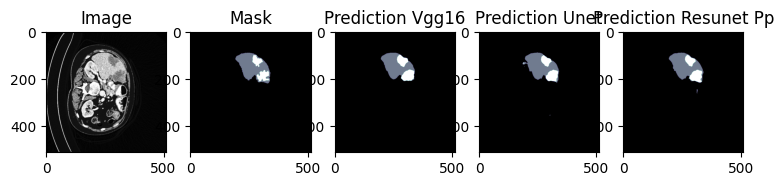

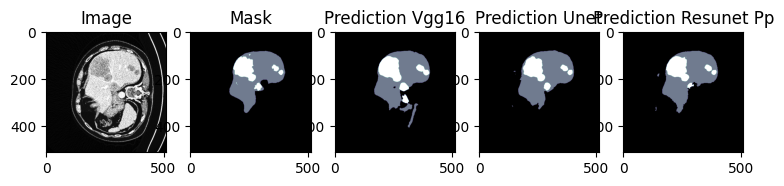

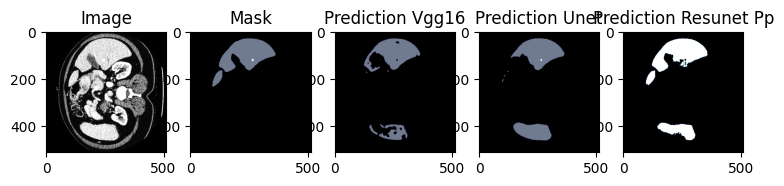

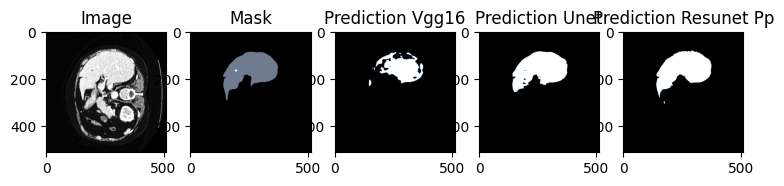

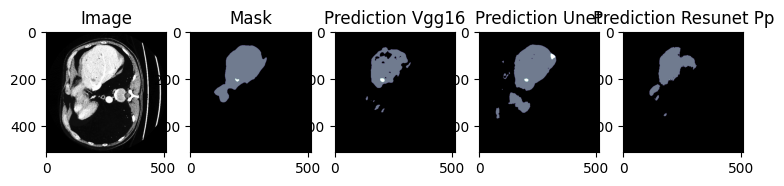

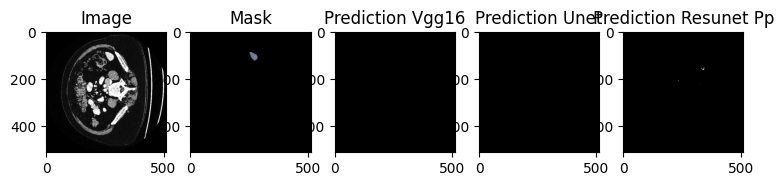

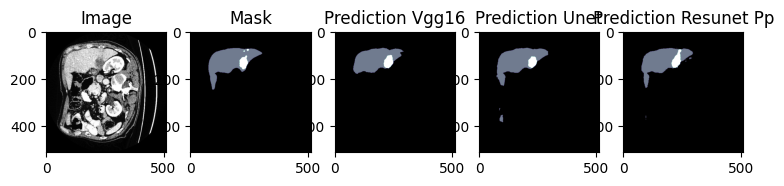

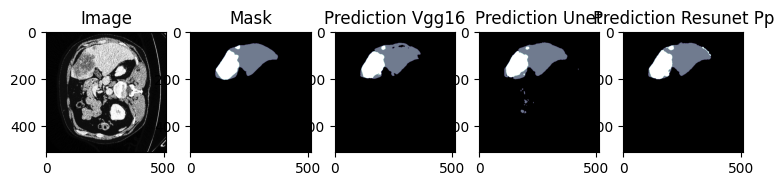

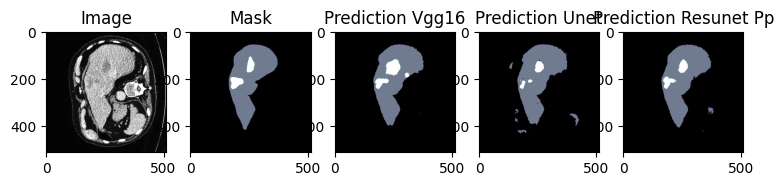

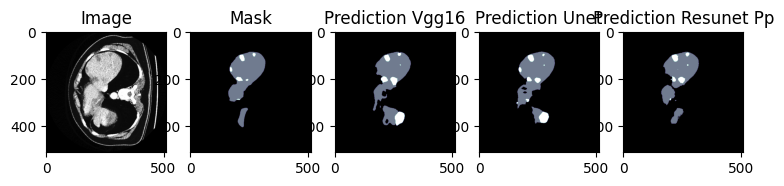

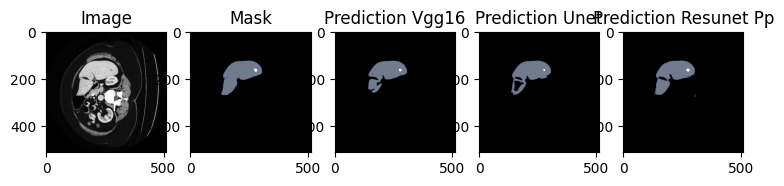

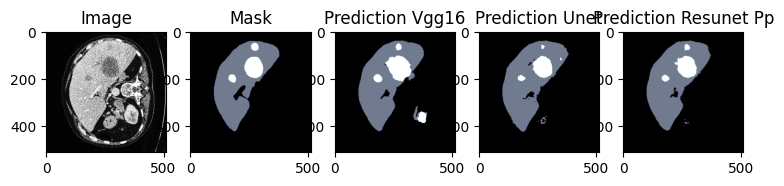

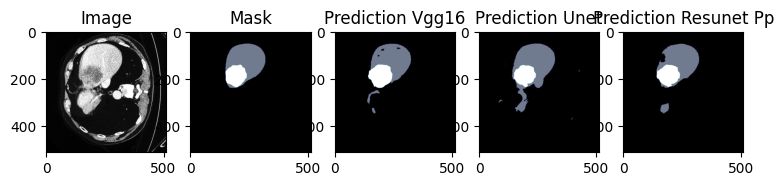

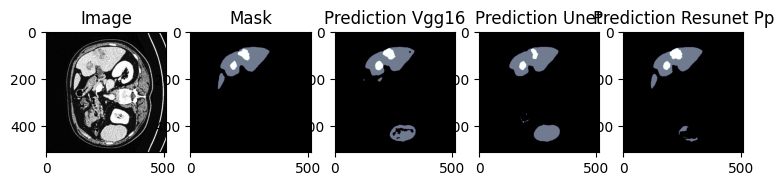

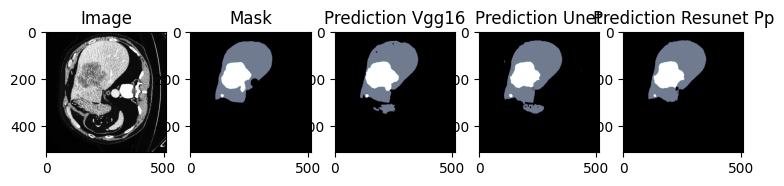

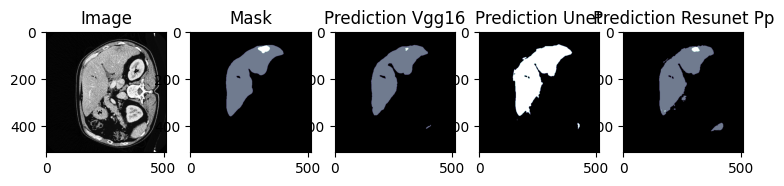

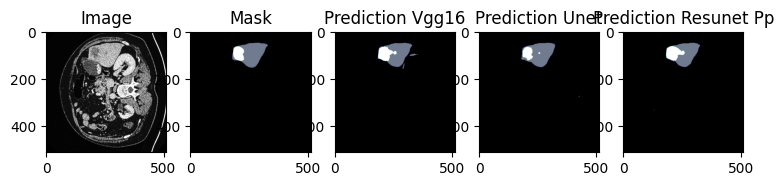

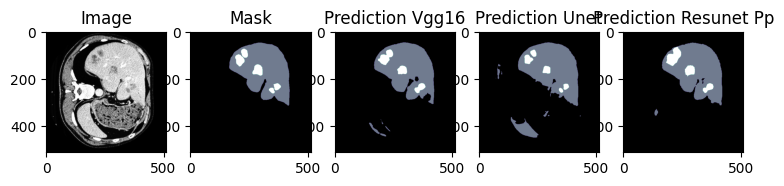

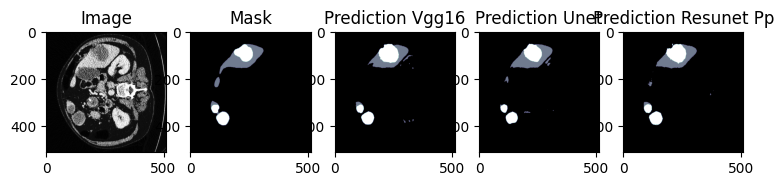

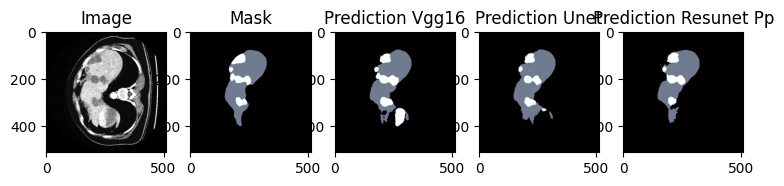

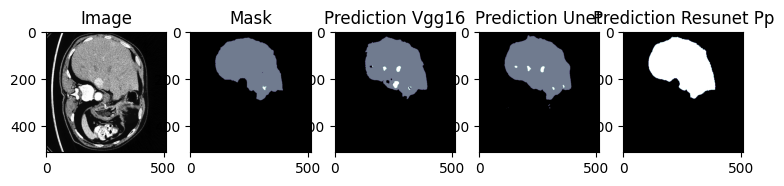

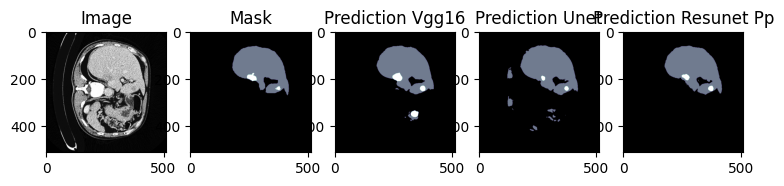

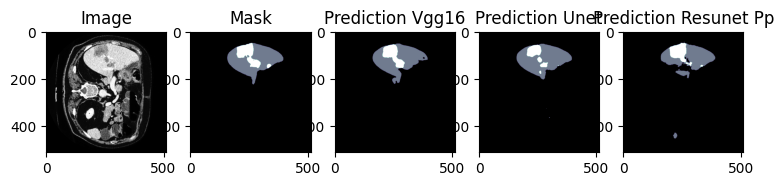

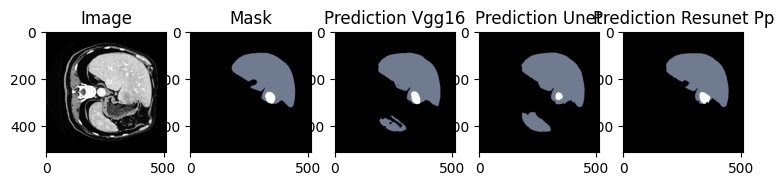

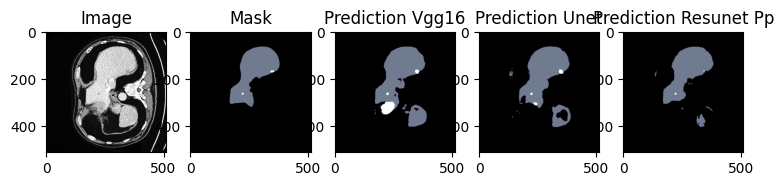

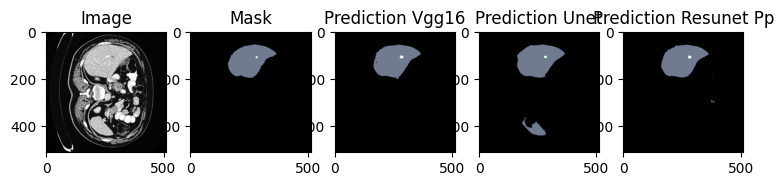

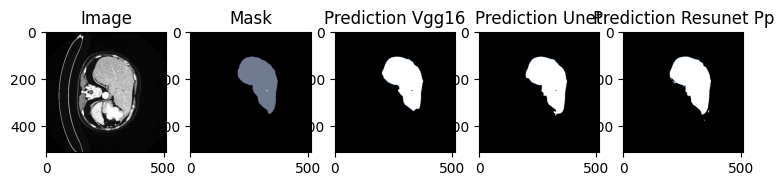

In [19]:
import random

l = random.sample(range(712), 30)


for i in l:
    img = test_x[i]
    image = read_image(img)

    image = np.expand_dims(image,axis=0)

    prediction_vgg16 = vgg16_unet.predict(image).squeeze()
    prediction_vgg16 = np.argmax(prediction_vgg16, axis=-1).astype(np.int32)

    prediction_unet = unet.predict(image).squeeze()
    prediction_unet = np.argmax(prediction_unet, axis=-1).astype(np.int32)

    prediction_resunet_pp = resunet_plus_plus.predict(image).squeeze()
    prediction_resunet_pp = np.argmax(prediction_resunet_pp, axis=-1).astype(np.int32)
    
    visualize(image = read_image(test_x[i]), mask = read_mask(test_y[i]), 
    prediction_vgg16 = prediction_vgg16, 
    prediction_unet = prediction_unet,
    prediction_resunet_pp = prediction_resunet_pp)